# Geradores

## $ \pi^*$

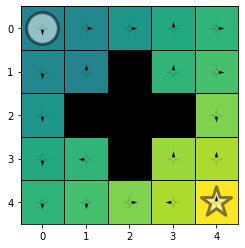

In [1]:
import numpy as np
from grid import Grid
from plot import plotPolicy, plotStateValue, plotActionStateValue, plotEffects, plotTrajectory

g = Grid()
g.pi_star(epsilon=.05)
# g.q_star()

ax = plotEffects(g)
plotPolicy(g.PI, g, ax=ax)
plotActionStateValue(g.Q, g, ax=ax)
# np.array([sum(q) for q in g.Q]).reshape(*g.size)
# g.PI
pi_star = g.PI

## $ h_1 $ 


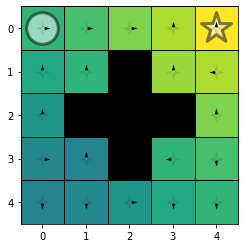

In [2]:
h1 = Grid()
target_1 = 4
h1.effects[(4,4)] = {'noise': lambda a: [-a[0], -a[1]]}
h1.effects[h1.S[target_1]] = {'terminal': True, 'reward': 10}

h1.pi_star(epsilon=.05)

ax = plotEffects(h1)
plotPolicy(h1.PI, h1, ax=ax)
plotActionStateValue(h1.Q, h1, ax=ax)

pi_1 = h1.PI

## $ h_2 $ 

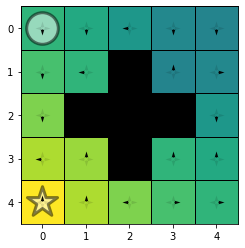

In [3]:
h2 = Grid()

target_2 = 20
h2.effects[(4,4)] = {'noise': lambda a: [-a[0], -a[1]]}
h2.effects[h2.S[target_2]] = {'terminal': True, 'reward': 10}

h2.pi_star(epsilon=.05)

ax = plotEffects(h2)
plotPolicy(h2.PI, h2, ax=ax)
plotActionStateValue(h2.Q, h2, ax=ax)

pi_2 = h2.PI

## $ \xi $

$ \eta(h|s) = \{^{.95 \;\; se \;\; s \in S^h}_{.05 \;\; se \;\; s \notin S^h} \;\; \forall h \in \mathcal{H} \; e \; \forall s \in S$ <br>
$ \pi_h(a|s) = \{^{.9625 \;\; se \;\; a = a^*}_{.0125 \;\; se \;\; a \ne a^*}  \;\; \forall a \in A \; e \; \forall s \in S$ <br>
$ \psi_h(s) = 0.3 \;\; \forall s \in S$

In [4]:
def generateTheta(S, eta=None, pis=None, psis=None):
    if eta is None:
        eta = {
            0: list(set(range(10, 25)) - {14}),
            1: list(range(10))+[14], 
        }
    if psis is None:
        psis = [[.3 for _ in g.S]]*2
    if pis is None: 
        pis = [pi_1, pi_2]
    
    H = list(zip(pis, psis))
    _eta = np.array([[.95 if s in eta[h] else .05 for h,_ in enumerate(H)] for s,_ in enumerate(S)])

    return H, _eta
    
generateTheta(g.S)

([(array([[0.0125, 0.0125, 0.9625, 0.0125],
          [0.0125, 0.0125, 0.9625, 0.0125],
          [0.0125, 0.0125, 0.9625, 0.0125],
          [0.9625, 0.0125, 0.0125, 0.0125],
          [0.9625, 0.0125, 0.0125, 0.0125],
          [0.9625, 0.0125, 0.0125, 0.0125],
          [0.9625, 0.0125, 0.0125, 0.0125],
          [0.9625, 0.0125, 0.0125, 0.0125],
          [0.9625, 0.0125, 0.0125, 0.0125],
          [0.0125, 0.0125, 0.0125, 0.9625],
          [0.9625, 0.0125, 0.0125, 0.0125],
          [0.9625, 0.0125, 0.0125, 0.0125],
          [0.9625, 0.0125, 0.0125, 0.0125],
          [0.9625, 0.0125, 0.0125, 0.0125],
          [0.9625, 0.0125, 0.0125, 0.0125],
          [0.0125, 0.0125, 0.9625, 0.0125],
          [0.9625, 0.0125, 0.0125, 0.0125],
          [0.9625, 0.0125, 0.0125, 0.0125],
          [0.0125, 0.0125, 0.0125, 0.9625],
          [0.0125, 0.9625, 0.0125, 0.0125],
          [0.0125, 0.9625, 0.0125, 0.0125],
          [0.0125, 0.9625, 0.0125, 0.0125],
          [0.0125, 0.0125, 0.962

<AxesSubplot: >

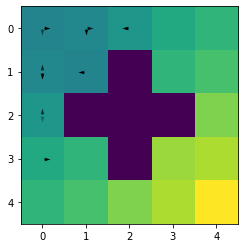

In [5]:
import random

def generateTrajetoryPi(pi, g, size=10):
    s = 0

    arr = []
    for _ in range(size-1):
        a  = random.choices(list(range(len(g.A))), pi[s], k=1)[0]
        step =  (s, a)
        s,_,_ = g.transition(s,  a)
        arr.append(step)
    arr.append((s, None))

    return arr

def generateTrajetory(H, eta, g, size=10):
    s = 0
    b = 1
    h = None
    arr = []
    for _ in range(size-1):
        if b == 1:
            h = random.choices(list(range(len(eta[s]))), eta[s], k=1)[0]
        
        pi, psi = H[h]
        
        a  = random.choices(list(range(len(pi[s]))), pi[s], k=1)[0]
        step =  (s, a)
        s,_,_ = g.transition(s,  a)
        arr.append(step)
        b = random.choices([0,1], [1-psi[s], psi[s]], k=1)[0]
    arr.append((s, None))

    return arr


tH = {1: list(range(10))+[14], 0: list(set(range(10, 25)) - {14}) }
psi_1 = [.3 for _ in g.S]
psi_2 = [.3 for _ in g.S]
H = [
    (pi_1, psi_1),
    (pi_2, psi_2)
]
eta = np.array([[.95 if s in tH[h] else .05 for h,_ in enumerate(H)] for s,_ in enumerate(g.S)])

E = generateTrajetory(H, eta, g, 15)
# E = generateTrajetoryPi(pi_star, g)

# ax = plotEffects(g)
# plotPolicy(h_2.PI, h_2, ax=ax)
ax = plotTrajectory(E, g)
plotActionStateValue(g.Q, g, ax=ax)

# Gradient Descent

In [6]:
def get_eg_from_theta(E, psi):
    H, eta = generateTheta(g.S, psis=psi)
    ddo = DDO(E, H, eta)
    return ddo.expectation_gradient()

## Single Trajectory

### Expectation Gradient

$ \nabla_{\theta}L[\theta;\xi] = \sum_{h \in \mathcal{H}} \; \lgroup \; \sum_{t=0}^{T-1} \;\lgroup\; v_t(h) \nabla_{\theta} log \eta(h|s_t) + u_t(h) \nabla_{\theta} log \pi_h(a_t|s_t)
\;\rgroup\; + \sum_{t=0}^{T-2} \;\lgroup\; (u_t(h) - w_t(h)) \nabla_{\theta} log \psi_h(s_{t+1}) + w_t(h) \nabla_{\theta} log (1-\psi_h(s_{t+1})) \;\rgroup\;\;\rgroup\; $ 

Sendo:<br><br>
$ \nabla_{\theta} log \eta(h|s_t) = \frac{\partial log \eta(h|s_t)}{\partial \theta} = \frac{1}{\eta(h|s_t)} \frac{\partial \eta(h|s_t)}{\partial \theta} = \frac{1}{\eta(h|s_t)} * 0 = 0        $ <br><br>
$ \nabla_{\theta} log \pi_h(a_t|s_t) = \frac{\partial log \pi_h(a_t|s_t)}{\partial \theta} = \frac{1}{\pi_h(a_t|s_t)} \frac{\partial \pi_h(a_t|s_t)}{\partial \theta} = \frac{1}{\pi_h(a_t|s_t)}  * 0 = 0   $ <br><br>
$ \nabla_{\theta} log \psi_h(s_{t+1}) = \frac{\partial log \psi_h(s_{t+1})}{\partial \theta} = \frac{1}{\psi_h(s_{t+1})} \frac{\partial \psi_h(s_{t+1})}{\partial \theta} = \frac{1}{\psi_h(s_{t+1})} * 1 = \frac{1}{\psi_h(s_{t+1})}      $ <br><br>
$ \nabla_{\theta} log (1-\psi_h(s_{t+1})) = \frac{\partial log (1-\psi_h(s_{t+1}))}{\partial \theta} = \frac{1}{1-\psi_h(s_{t+1})} (-\frac{\partial \psi_h(s_{t+1})}{\partial \theta}) = \frac{1}{1-\psi_h(s_{t+1})} * 1 = \frac{1}{1-\psi_h(s_{t+1})}   $

In [7]:
from ddo import DDO 
import random 

def GradientDescent(E, S, param=None, learning_rate=.001, max_trials=1000):
    if param is None:
        param = random.random()
    for _ in range(max_trials):
        # print(f'param: {param}')
        param = param + learning_rate * get_eg_from_theta(E, [[param for _ in S]]*2)              
    return  param
        

E = generateTrajetory(*generateTheta(g.S, psis=[[.3 for _ in g.S]]*2), g, 20)
print('estimative: ')
GradientDescent(E, g.S)

estimative: 


0.15023966910008107

<AxesSubplot: >

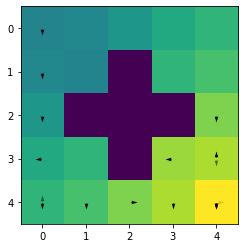

In [8]:
ax = plotTrajectory(E, g)
plotActionStateValue(g.Q, g, ax=ax)

### Experimentos

In [47]:
import random 

def GradientDescent(Es, S, param=None, learning_rate=.0001, max_trials=50):
    if param is None:
        param = random.random()
    for _ in range(max_trials):
        # print(f'param: {param}')
        param = param + learning_rate * sum(get_eg_from_theta(E, [[param for _ in S]]*2) for E in Es)
    return  param
        

n = 100
size_range = (10, 30)
Es = [generateTrajetory(*generateTheta(g.S, psis=[[.3 for _ in g.S]]*2), g, random.randrange(*size_range)) for _ in range(n)] 
print('estimative: ')
GradientDescent(Es, g.S)

estimative: 


0.12964307398993807

### Stochastic

In [48]:
import random 

def GradientDescent(Es, S, param=None, learning_rate=.001, max_trials=50):
    if param is None:
        param = random.random()
    for _ in range(max_trials):
        # print(f'param: {param}')
        param = param + learning_rate * get_eg_from_theta(random.choice(Es), [[param for _ in S]]*2)
    return  param
        

n = 100
size_range = (10, 50)
Es = [generateTrajetory(*generateTheta(g.S, psis=[[.3 for _ in g.S]]*2), g, random.randrange(*size_range)) for _ in range(n)] 
print('estimative: ')
GradientDescent(Es, g.S)

estimative: 


0.12406141876128074

estimative: 


Text(0.5, 0, 'theta')

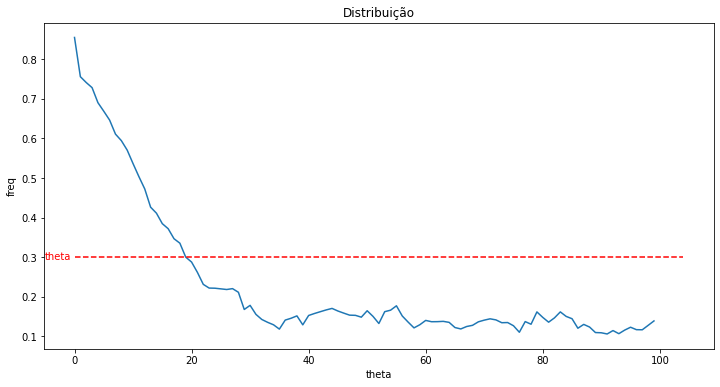

In [50]:
import matplotlib.pyplot as plt

def GradientDescent(Es, S, param=None, learning_rate=.001, max_trials=100):
    if param is None:
        param = random.random()
    for _ in range(max_trials):
        # print(f'param: {param}')
        param = param + learning_rate * get_eg_from_theta(random.choice(Es), [[param for _ in S]]*2)
        yield  param

theta = .3
n = 100
size_range = (10, 50)
Es = [generateTrajetory(*generateTheta(g.S, psis=[[theta for _ in g.S]]*2), g, random.randrange(*size_range)) for _ in range(n)] 
print('estimative: ')



fig, axs = plt.subplots(1,1, figsize=(12,6))

y = [p for p in GradientDescent(Es, g.S)]
x = range(len(y))
m = len(y)

axs.plot(x, y)
axs.plot(range(m+5), [theta for _ in range(m+5)], color='red', linestyle='dashed')
axs.text(-5, theta-.006, 'theta', color='red')
axs.set_title(f'Distribuição')
axs.set_ylabel('freq')
axs.set_xlabel('theta')
